# SwapPricing Workbook
--- Nov-19-2019, Alan, Shaolun.du@gmail.com

This is a detailed documentation on Swap Pricing. In the following, I will go over three different types of swaps and detailed on how to price them with QuantLib, in the end I will talk about how to make the pricing to take customized amortization sechdule, which is useful for corporate hedging solutions: 

- Vanilla swap: Basic floating v.s. fixed swap same currency.
- XCS(cross currency swap): Basic floating v.s. fixed swap different currency.
- Basis swap: Floating v.s. Floating swap with different rate index same currency.

After pricing, I will go over the proceduer to generate a full set of risk matrics for a single swap. They are: DV01, PV01, KRDs with key years points. Forward cash flow changes and NPV changes when curve shocked. (This will include some of the curve shcoking method that is quiet useful in stress testing.)

*** NOTE: I will use USD curve as an example going forward, and I will talk about how to get other major currency curves as variantion to USD curves in the end. For XCS pricing, I will use USD/EUR cross currency swap as example.***

## 1 - Vanilla Swap Pricing

To start, please import the library:

In [1]:
import math
import numpy as np
import QuantLib as ql
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Helper function for curve building please refer to previous post
# Pull out a yield curve for pricing
# Details please refer to previous workbook, we will use USD LIBOR curve here.
Con_dict = {
# All details listed here is directly from the market instruments
# If changed to another sets of market instruments please update details here!
    "Cash":{ "DayCount":ql.Actual360(),
             "EOM":False, # Check if end of month please change correspondingly
             "BsDay":ql.ModifiedFollowing,
             "Calendar":ql.UnitedStates(),
             "SettlementDays": 2, # Settlement shift after fixing
           },
    "Future":{ "DayCount":ql.Actual360(),
               "EOM":False, # Check if end of month please change correspondingly
               "BsDay":ql.ModifiedFollowing,
               "ConVes_Adj":ql.QuoteHandle(ql.SimpleQuote(0.0)),# For convexity adjustment
               "Calendar":ql.UnitedStates(),
               "SettlementDays": 2, # Settlement shift after fixing
               "LengthInMonths": 3,
             },
    "Swap":{  "Index":ql.USDLibor(ql.Period(3,ql.Months)), # Floating Leg index rate
              "FloatingLegTenor":ql.Period(3,ql.Months),
              "FloatingLegFrequency":ql.Quarterly,
              "FloatingLegAdjustment":ql.ModifiedFollowing,
              "FloatingLegDayCounter":ql.Actual360(),
              "FixedLegFrequency":ql.Semiannual,
              "FixedLegTenor":ql.Period(6,ql.Months),
              "FixedLegAdjustment":ql.ModifiedFollowing,
              "FixedLegDayCounter":ql.Thirty360(),
              "SettlementDays": 2, # Settlement shift after fixing
              "Calendar":ql.UnitedStates(),
            },
}
Mkt_dict = {
    "SDate": ql.Date(18,11,2019), # Curve starting date
    "Cash":{ (1,ql.Months): 0.018325,
             (3,ql.Months): 0.019026,
             (6,ql.Months): 0.019185,
           },
    "Future":{ # IMM dates can be automated using above functions
               # For clearly here I keep it as inputs date values
               ql.Date(18,12,2019): 98.1125,
               ql.Date(18,3,2020): 98.325,
               ql.Date(17,6,2020): 98.415,
               ql.Date(16,9,2020): 98.49,
               ql.Date(16,9,2020): 98.49,
               ql.Date(16,9,2020): 98.55,
             },
    "Swap":{  (2,ql.Years): 0.01604,
              (3,ql.Years): 0.0157,
              (4,ql.Years): 0.01567,
              (5,ql.Years): 0.015785,
              (6,ql.Years): 0.01597,
              (7,ql.Years): 0.0162,
              (8,ql.Years): 0.016475,
              (9,ql.Years): 0.01677,
              (10,ql.Years): 0.01705,
              (11,ql.Years): 0.017315,
              (12,ql.Years): 0.01756,
              (15,ql.Years): 0.01811,
              (20,ql.Years): 0.01869,
              (25,ql.Years): 0.0189,
              (30,ql.Years): 0.018932,
              (40,ql.Years): 0.01873,
            },
}
def Bootstrapping( Market, Convention ):
    sDate = Market["SDate"]
    ql.Settings.instance().evaluationDate = sDate
    # Convert market quotes into QuantLib "Quote objects"
    deposits = Market["Cash"]
    futures  = Market["Future"]
    swaps    = Market["Swap"]
    deposits_con  = Convention["Cash"]
    futuresc_con  = Convention["Future"]
    swaps_con     = Convention["Swap"]
    for n,unit in deposits.keys():
        deposits[(n,unit)] = ql.SimpleQuote(deposits[(n,unit)])
    for d in futures.keys():
        futures[d] = ql.SimpleQuote(futures[d])
    for n,unit in swaps.keys():
        swaps[(n,unit)] = ql.SimpleQuote(swaps[(n,unit)])
    # Build up helpers for curve building
    depositHelpers = [ ql.DepositRateHelper( ql.QuoteHandle(deposits[(n,unit)]),
                                             ql.Period(n,unit), deposits_con["SettlementDays"],
                                             deposits_con["Calendar"], deposits_con["BsDay"],
                                             deposits_con["EOM"], deposits_con["DayCount"])
                       for n, unit in deposits.keys() ]
    futuresHelpers = [ ql.FuturesRateHelper( ql.QuoteHandle(futures[d]),
                                             d, futuresc_con["LengthInMonths"],
                                             futuresc_con["Calendar"], futuresc_con["BsDay"],
                                             futuresc_con["EOM"], futuresc_con["DayCount"],
                                             futuresc_con["ConVes_Adj"])
                       for d in futures.keys() ]
    swapHelpers = [ ql.SwapRateHelper( ql.QuoteHandle(swaps[(n,unit)]),
                                       ql.Period(n,unit), swaps_con["Calendar"],
                                       swaps_con["FixedLegFrequency"], swaps_con["FixedLegAdjustment"],
                                       swaps_con["FixedLegDayCounter"], swaps_con["Index"])
                    for n, unit in swaps.keys() ]
    # term-structure construction
    helpers = depositHelpers + futuresHelpers + swapHelpers # Helpers combined
    yts = ql.PiecewiseFlatForward( sDate, helpers, ql.Actual360()) # Forward curve defination
    yts.enableExtrapolation()
    return yts

In [3]:
# Generate USE LIBOR yield curve with TermStructure object
yts = Bootstrapping(Mkt_dict, Con_dict)
hyts = ql.RelinkableYieldTermStructureHandle(yts) # Build discounting curve into a term structure
f_hyts = ql.RelinkableYieldTermStructureHandle(yts) # Build forward curve term structure

To construct a VanillaSwap, we have to invoke VanillaSwap module and pre-setup its fixed leg and floating leg. See below:

In [4]:
# Swap object defined as a dictionary with float leg and fixed leg
# Inorder to advance date in Quantlib we have to use a calender object
t_calendar = ql.UnitedStates()
settle_date = ql.Date(18, 11, 2021)
maturity_date = ql.Date(18, 11, 2026)
LiborXm = ql.USDLibor(ql.Period(3, ql.Months),hyts)
V_Swap_Dict = {
    "Type":ql.VanillaSwap.Payer,
    "Notional":100000000,
    "Fixed_Leg":{
        "fixedSchedule":ql.Schedule( settle_date, 
                                     maturity_date, 
                                     ql.Period(6, ql.Months), ql.UnitedStates(),
                                     ql.ModifiedFollowing, ql.ModifiedFollowing,
                                     ql.DateGeneration.Forward, False),
        "fixedRate":0.02,
        "fixedDayCount":ql.Thirty360(),
    },
    "Float_Leg":{
        "floatSchedule": ql.Schedule( settle_date, 
                                      maturity_date, 
                                      ql.Period(3, ql.Months), ql.UnitedStates(),
                                      ql.ModifiedFollowing, ql.ModifiedFollowing,
                                      ql.DateGeneration.Forward, False),
        "index":LiborXm,
        "spread":0,
        "floatingDayCount":ql.Actual360(),
    },
}
V_Swap = ql.VanillaSwap( V_Swap_Dict["Type"], 
                         V_Swap_Dict["Notional"], 
                         V_Swap_Dict["Fixed_Leg"]["fixedSchedule"], 
                         V_Swap_Dict["Fixed_Leg"]["fixedRate"], 
                         V_Swap_Dict["Fixed_Leg"]["fixedDayCount"], 
                         V_Swap_Dict["Float_Leg"]["floatSchedule"],
                         V_Swap_Dict["Float_Leg"]["index"],
                         V_Swap_Dict["Float_Leg"]["spread"], 
                         V_Swap_Dict["Float_Leg"]["floatingDayCount"] )

Pricing this vanilla swap and generate a set of risks factors.

In [5]:
# Simple resules
swap_engine = ql.DiscountingSwapEngine(hyts)
V_Swap.setPricingEngine(swap_engine)
print("Swap NPV={}".format(V_Swap.NPV()))
print("Swap Fair Rate={}".format(V_Swap.fairRate()))

Swap NPV=-1733524.4255623668
Swap Fair Rate=0.01626321319210249


## 1 - a Vanilla Swap Pricing Testing

The basic logic to validate a swa pricing is almost the same as if to valid a curve.
We will input all market instruments when bootstrap and see if the result is close enough with just pricing on this curve.

Below let me introduce a helper function to generate a set of testing swaps:

***NOTE***:
1. When implementing swap object, the floating leg needs to connect with actual term structure we are using. In the below example, we are using market curve built from cash rates, future rates and swap rates. the curve afterwards generated as a termstructure handler 'hyts = ql.YieldTermStructureHandle(yts)' and been settled into floating leg index see 'ql.USDLibor(ql.Period(3,ql.Months),hyts)'.
2. For most of the swap traded in the market, the settlement date always T+2, meaning after trade confirmed it still needs 2 buisness day to actually settle the trade.
3. This example I am not considering the amortization sechdule which always different when doing interests hedging buisness. Later in this workbook, I will talk about how to handle the amortization schedule properly.

In [ ]:
# Swap test helper
def Test_helper( inst ):
    swap_li = []
    for ele in inst.keys():
        t_calendar = ql.UnitedStates()
        settle_date = t_calendar.advance(Mkt_dict["SDate"], 2, ql.Days)
        maturity_date = t_calendar.advance(settle_date, ele[0], ql.Years)
        V_Swap_Dict = {
            "Type":ql.VanillaSwap.Payer,
            "Notional":100000000,
            "Fixed_Leg":{
                "fixedSchedule":ql.Schedule( settle_date, 
                                             maturity_date, 
                                             ql.Period(6, ql.Months), ql.UnitedStates(),
                                             ql.ModifiedFollowing, ql.ModifiedFollowing,
                                             ql.DateGeneration.Forward, False),
                "fixedRate":inst[ele],
                "fixedDayCount":ql.Thirty360(),
            },
            "Float_Leg":{
                "floatSchedule": ql.Schedule( settle_date, 
                                              maturity_date, 
                                              ql.Period(3, ql.Months), ql.UnitedStates(),
                                              ql.ModifiedFollowing, ql.ModifiedFollowing,
                                              ql.DateGeneration.Forward, False),
                "index":ql.USDLibor(ql.Period(3,ql.Months),hyts),
                "spread":0,
                "floatingDayCount":ql.Actual360(),
            },
        }
        V_Swap = ql.VanillaSwap( V_Swap_Dict["Type"], V_Swap_Dict["Notional"], V_Swap_Dict["Fixed_Leg"]["fixedSchedule"], 
                                 V_Swap_Dict["Fixed_Leg"]["fixedRate"], V_Swap_Dict["Fixed_Leg"]["fixedDayCount"], 
                                 V_Swap_Dict["Float_Leg"]["floatSchedule"],
                                 V_Swap_Dict["Float_Leg"]["index"],
                                 V_Swap_Dict["Float_Leg"]["spread"], V_Swap_Dict["Float_Leg"]["floatingDayCount"] )
        swap_li.append(V_Swap)
    return swap_li

In [ ]:
# Testing for curve validation
Testing_Ins = {
    (2,ql.Years): 0.01604,
    (3,ql.Years): 0.0157,
    (4,ql.Years): 0.01567,
    (5,ql.Years): 0.015785,
    (6,ql.Years): 0.01597,
    (7,ql.Years): 0.0162,
    (8,ql.Years): 0.016475,
    (9,ql.Years): 0.01677,
    (10,ql.Years): 0.01705,
    (11,ql.Years): 0.017315,
    (12,ql.Years): 0.01756,
    (15,ql.Years): 0.01811,
    (20,ql.Years): 0.01869,
}
testers = Test_helper(Testing_Ins)
Errors = []
Rates  = []
swap_engine = ql.DiscountingSwapEngine(hyts)
for swap_test in testers:
    swap_test.setPricingEngine(swap_engine)
    Errors.append(swap_test.NPV())
    Rates.append(swap_test.fairRate())
print("###---Test case one---###")
print("Swap with Par Swap rate should have NPV=0:")
print(Errors)
print("Mean Error={}".format(np.mean(Errors)))
print("###---Test case two---###")
print("back Solve Par swap rate should be close to Actual Par Swap rate:")
act_rate = [Testing_Ins[key] for key in Testing_Ins.keys()]
Rate_error = [ele1-ele2 for ele1,ele2 in zip(act_rate,Rates)]
print(Rate_error)
print("Mean Rates Error={}".format(np.mean(Rate_error)))


## 1 - b More on Swap Pricing

***With this example***: Before get involved into cross currency swap and basis swap, let's dig a little bit more into the QuantLib Swap pricing engine. I will walk you through the followings:
1. How to change pricing date, inorder to generate a potential exposure given current yield curve.
2. How to generate a full set of Risk Metrics includes: DV01, KRDs.
3. How to do curve shocking and generate delta projected cash flow as well as delta values.
4. How to use custormized amortization schedule.

In [ ]:
# How to change pricing date into a date in the future
Pricing_Date = ql.Date(18,11,2021)
# In order to price swap in the future
#    we need to add Libor fixing date into YieldTermStructure
#    For all floating fixing date
#    Here we will add another row into V_Swap_Dict to get all libor fixing dates
###--- Get all flaoting leg fixing date ---###
fixing_date = [V_Swap_Dict["Float_Leg"]["index"].fixingDate(x) for x in V_Swap_Dict["Float_Leg"]["floatSchedule"]][:-1]
for loc in range(len(fixing_date)-1):
        if fixing_date[loc] <= Pricing_Date:
            fixing = V_Swap_Dict["Float_Leg"]["index"].fixing(fixing_date[loc])
            V_Swap_Dict["Float_Leg"]["index"].addFixing(fixing_date[loc],fixing)
# After fixing forward LIBOR we are now safe to change valuation date below:
ql.Settings.instance().evaluationDate = Pricing_Date
print(V_Swap.NPV())

***1-b-1: About Forward Exposure Path***: With above method, let's try to generate a full forward NPV path for this example swap. This type of calcualtion will be extremely useful when we move to the topic about XVA calculation which will need us to use projected future NPV path to get exposure calculation.

* For a sawp NPV it should decrease value in terms of absolute value when time past. For example, the below graph starting from a negative value (meaning current swap is out of money) the nas time past by its value getting closer to zero until it is maturitied.
* If working in C++ there will be another parameter in addFixing(date,fixing, Overwrite?) inorder to force overwrite fixing data. However, in python there is no such option. What I can do here is to gradually adding in those fixing dates as we are calculating future exposure.
* There might be an issue since the output graph does not end at zero which in theory it should be.

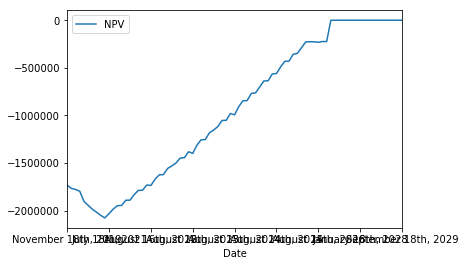

In [6]:
# Wrapup the above process into a forward value calcualtion function
from matplotlib import pyplot as plt
import pandas as pd
ql.IndexManager.instance().clearHistory(LiborXm.name())
LiborXm = ql.USDLibor(ql.Period(3, ql.Months),hyts)
NPV_li = []
MAX_year = 10
today = ql.Date(18,11,2019)
timegrid = [ today + ql.Period(i*2, ql.Months) for i in range(6*MAX_year) ]
timegrid += [LiborXm.fixingDate(x) for x in V_Swap_Dict["Float_Leg"]["floatSchedule"]]
timegrid = np.sort(np.unique(timegrid)) # merge fixing date and pricing date
for date in timegrid:
    # Step 0: change setting date
    ql.Settings.instance().evaluationDate = date
    # Step 1: adding fixing date
    if LiborXm.isValidFixingDate(date) and date > today:
        fixing = LiborXm.fixing(date)
        LiborXm.addFixing(date,fixing)
    # Step 2: get NPV
    NPV = V_Swap.NPV()
    NPV_li.append({"Date":date,"NPV":NPV})
df = pd.DataFrame(NPV_li).set_index("Date")
df.plot()

***1-b-2:Risk Metrics Calculation***: DV01 and KRDs, those basic type of risk metrics are not directly provided by QuantLib. In the following, I will walk you through how to use curve shocking method to generate all risk metrics. Let's start with DV01 and then implement KRD_Y year.

In [ ]:
# DV01 Calculation using curve shocking method
# Fixed-rate receiver is long a bond with coupon S and Floater has no risk;
# Therefore DV01 is fixed leg BPS
DV01 = abs(V_Swap.fixedLegBPS())
print('DV01={}'.format(DV01))

In [ ]:
# To calculate KRDs we will use key rate point with shokcing curves
nodes = [ 1, 2, 3, 5, 7, 10, 12, 15, 20, 25, 30 ]  # the durations
dates = [ Mkt_dict["SDate"] + ql.Period(n, ql.Years) for n in nodes ]
spreads = [ ql.SimpleQuote(0.0) for n in nodes ] # null spreads to begin
krd_curve = ql.SpreadedLinearZeroInterpolatedTermStructure( 
                ql.YieldTermStructureHandle(yts),
                [ql.QuoteHandle(q) for q in spreads],
                dates )
hyts.linkTo(krd_curve)
KRDs = {}
Current_NPV = V_Swap.NPV() # Remember current NPV
for ele,dtt in zip(spreads,nodes):
    for tt in spreads: # Clear current settings
        tt.setValue(0.0)
    ele.setValue(0.0001) # Set shocking 1bps
    KRDs[dtt]=V_Swap.NPV()-Current_NPV
print(KRDs)
# Quick test with sum of KRDs to DV01
KRD_sum = sum([val for k,val in KRDs.items()])

print("---Compare to DV01---")
print("DV01={},SumKRDs={},Diff={}".format(DV01,KRD_sum,DV01-KRD_sum))

# Scenrio analysis
# Shock the curve by 0 bps at 2 year and 10 bps at 5 year and going forward
# This is a typical curve steepening shock from Y2 to Y5
# NOTE: Later on we will write a function for this type of functioning
for tt in spreads: # Clear current settings
    tt.setValue(0.0)
spreads[2].setValue(0.0003)
for i in range(3,11):
    spreads[i].setValue(0.0010)
print("Steepening Y2 to Y5 Delta={}".format(V_Swap.NPV()-Current_NPV))

***Stress Testing Shocking Function***: This shocking function designed for less than 30 years different type of curve shocking analysis. One can also do convexity shock or any type of customized shocking. In this example I only list out steepening/flatening shock.

In [ ]:
def get_shock_delta( swap_obj, yts_cur, hyts_cur,
                     start_y, end_y, bps ):
    if end_y<start_y:
        print("Wrong time window! Return 0...")
        return 0
    Current_NPV = swap_obj.NPV() # Remember current NPV
    nodes = list(range(1,31))  # the durations
    dates = [ Mkt_dict["SDate"] + ql.Period(n, ql.Years) for n in nodes ]
    spreads = [ ql.SimpleQuote(0.0) for n in nodes ] # null spreads to begin
    krd_curve = ql.SpreadedLinearZeroInterpolatedTermStructure( 
                    ql.YieldTermStructureHandle(yts_cur),
                    [ql.QuoteHandle(q) for q in spreads],
                    dates )
    hyts_cur.linkTo(krd_curve)
    for tt in spreads: # Clear current settings
        tt.setValue(0.0)
    delta = bps/(end_y-start_y)/10000
    for i in range(start_y-1,30):
        spreads[i].setValue(min(bps/10000,(i-start_y+1)*delta))
    delta_val = Current_NPV-swap_obj.NPV()
    for tt in spreads: # Clear current settings
        tt.setValue(0.0)
    return delta_val

In [ ]:
# Example for stress shocking 
start = 2
end   = 5
shift = -10
delta = get_shock_delta( V_Swap, yts, hyts, 
                         start,  end, shift )
print(delta)

***1-b-3:CashFlow Sensitivity Calculation***: In the following I will list out some method to calculate cash flow sensitivity for a swap. Basically, what we are trying to do that is different from above is that instead of looking into fixed leg risks, we are looking into more floating leg changes. Meaning, if rates curve changes say 100 bps what will happen to our cash flow on this swap. In this case, the fixed leg will not change, but the floating leg will change correspondingly since it totally depend on yield curve. 

Now, let's take a look.

In [ ]:
# Cash flow snesitivity when rate curve changed
# Step One: Remember current Floating leg payments
cur_cf = []
for i,cf in enumerate(V_Swap.floatingLeg()):
    cur_cf.append([cf.date(),cf.amount()])
    print("Location={},Date={},Amount={}".format(i,cf.date(),cf.amount()))

In [ ]:
# Step two shock whole yield curve by 100 bps
nodes = list(range(0,31))  # the durations
dates = [ Mkt_dict["SDate"] + ql.Period(n, ql.Years) for n in nodes ]
spreads = [ ql.SimpleQuote(0.01) for n in nodes ] # null spreads to begin
fwd_curve = ql.SpreadedLinearZeroInterpolatedTermStructure( 
                ql.YieldTermStructureHandle(yts),
                [ql.QuoteHandle(q) for q in spreads],
                dates )
f_hyts.linkTo(fwd_curve)
# Reset whole swap since I cannot change only the forward curve on the fly
swap_engine = ql.DiscountingSwapEngine(f_hyts)
V_Swap.setPricingEngine(swap_engine)
new_cf = V_Swap.floatingLeg()
# Result from floating leg sensitivity analysis
for cf0,cf1 in zip(cur_cf,new_cf):
    sDate = cf0[0]
    t0 = cf0[1]
    t1 = cf1.amount()
    print("Date={}, OriginalCF={:,.0f}, After100BPSCF={:,.0f}, Delta={:,.0f}".format(sDate,t0,t1,t1-t0))
for tt in spreads: # Clear current settings
    tt.setValue(0.0)
# Reset swap engine back to origianl
swap_engine = ql.DiscountingSwapEngine(hyts)
V_Swap.setPricingEngine(swap_engine)

***1-b-4:How to take customized amortization schedule***: In the following I will talke about how to modify amortization schedule for a vanilla swap, this is useful for hedging purpose. 

In [ ]:
# Define a customized schedule below:
# In this example I am assuming a 3M vs 3M frequency schedule and 
# the amort table has the same
t_calendar = ql.UnitedStates()
settle_date = ql.Date(18, 11, 2021)
maturity_date = ql.Date(18, 11, 2026)
notiaonal = [100000000,80000000,60000000,40000000,
             20000000,20000000,20000000,20000000,]
fixed_rates = [0.02]*2*4

In [ ]:
# Swap Object is different from standard swap please take a look on documentation
V_Swap_Dict = {
    "Type":ql.VanillaSwap.Payer,
    "Notional":notiaonal,
    "Fixed_Leg":{
        "fixedSchedule":ql.Schedule( settle_date, 
                                     maturity_date, 
                                     ql.Period(3, ql.Months), ql.UnitedStates(),
                                     ql.ModifiedFollowing, ql.ModifiedFollowing,
                                     ql.DateGeneration.Forward, False),
        "fixedRate":fixed_rates,
        "fixedDayCount":ql.Thirty360(),
    },
    "Float_Leg":{
        "floatSchedule": ql.Schedule( settle_date, 
                                      maturity_date, 
                                      ql.Period(3, ql.Months), ql.UnitedStates(),
                                      ql.ModifiedFollowing, ql.ModifiedFollowing,
                                      ql.DateGeneration.Forward, False),
        "index":ql.USDLibor(ql.Period(3,ql.Months),f_hyts),
        "spread":0,
        "floatingDayCount":ql.Actual360(),
    },
}
floatingleg = ql.IborLeg( V_Swap_Dict["Notional"],V_Swap_Dict["Float_Leg"]["floatSchedule"],
                          V_Swap_Dict["Float_Leg"]["index"],V_Swap_Dict["Float_Leg"]["floatingDayCount"])
fixedleg    = ql.FixedRateLeg( V_Swap_Dict["Fixed_Leg"]["fixedSchedule"],
                               V_Swap_Dict["Fixed_Leg"]["fixedDayCount"],
                               V_Swap_Dict["Notional"],V_Swap_Dict["Fixed_Leg"]["fixedRate"])

A_Swap = ql.Swap( floatingleg,fixedleg )
swap_engine = ql.DiscountingSwapEngine(hyts)
A_Swap.setPricingEngine(swap_engine)
print(A_Swap.NPV())

## 2 - XCS(Cross Currency Swap) Swap Pricing

To begin with, let's review what is a XCS. In general, a XCS is a swap with two currencies to exchange with one fixed rate in leg one currency to a floating rate plus spread in leg two currency. For example, USD-EUR XCS could be paying EUR fixed rate at 4% and receive USD floating rate plus 3%. The motivation for investors doing this type of swap is to hedge their currency risk. If an investor has some ongoing project which generates fixed cash flow in EUR and that investor is based in US. Then get a XCS will be benifit to hedge currency risks instead of buying a lot of FRAs along the way.

***2-a:Steps for XCS valuation***:

* Make sure the collateral is setteled in which currency, for example USD-EUR XCS could settle in USD, if this is the case, then we will be building curves based on basis spread from EUR to USD.
* Build FX curve with LIBOR EUR plus EUR-USD basis spread. Details please refer to my previous post.(notebook:Bootstrapping)
* Apply different curve to different leg in swap engine and translate the result (NPV) with spot EURUSD rate. NPV = NPV of EUR Leg(translate to USD) + NPV of USD Leg.

***QuantLib has no implementation on this. But I have my own implementation available on GitHub.***
* What we can do for a simple approximation is by using tow bonds ith dual curve discounting.
Below is an implementation with above method:

For example, we are pricing a EUR vs USD XCS with:
* Notiaonal at the begining: USD 112MM and EUR 100MM
* Pay EUR 4% quaterly, ACT/360 -> Simulate with fixed rate bond.
* Rec USD 3%+3ML LIBOR quaterly, ACT/360 -> Simulate with floating rate bond.
* Current spotrate EURUSD = 1.10

In [ ]:
# Initialization
index = ql.USDLibor(ql.Period(3,ql.Months),hyts)
issueDate = settle_date
maturityDate = maturity_date
tenor = ql.Period(3, ql.Months)
calendar = ql.UnitedStates()
bussinessConvention = ql.ModifiedFollowing
dateGeneration = ql.DateGeneration.Backward
monthEnd = False
schedule = ql.Schedule( issueDate, maturityDate, tenor, 
                        calendar, bussinessConvention, bussinessConvention, 
                        dateGeneration, monthEnd )
dayCount = ql.Actual360()
Spread = 0.03
settlementDays = 2
faceValue = 112000000
USD_Leg = ql.FloatingRateBond(   settlementDays,
                                 faceValue,
                                 schedule,
                                 index,
                                 dayCount,
                                 bussinessConvention,
                                 0,
                                 [],   # Gearings
                                 [Spread],  # Spreads
                              )
bondEngine = ql.DiscountingBondEngine(hyts)
USD_Leg.setPricingEngine(bondEngine)
USD_NPV = USD_Leg.NPV()
print("USD NPV={:.0f}".format(USD_NPV))

In [ ]:
# EUR market instruments quotes
EUR_Con_dict = {
# All details listed here is directly from the market instruments
# If changed to another sets of market instruments please update details here!
    "Cash":{ "DayCount":ql.Actual360(),
             "EOM":False, # Check if end of month please change correspondingly
             "BsDay":ql.ModifiedFollowing,
             "Calendar":ql.TARGET(),
             "SettlementDays": 2, # Settlement shift after fixing
           },
    "FRA":{    "DayCount":ql.Actual360(),
               "EOM":False, # Check if end of month please change correspondingly
               "BsDay":ql.ModifiedFollowing,
               "fixingDays":2,# For convexity adjustment
               "Calendar":ql.TARGET(),
               "SettlementDays": 2, # Settlement shift after fixing
               "LengthInMonths": 3,
             },
    "Swap":{  "Index":ql.EURLibor(ql.Period(6,ql.Months)), # Floating Leg index rate
              "FloatingLegTenor":ql.Period(6,ql.Months),
              "FloatingLegFrequency":ql.Semiannual,
              "FloatingLegAdjustment":ql.ModifiedFollowing,
              "FloatingLegDayCounter":ql.Actual360(),
              "FixedLegFrequency":ql.Annual,
              "FixedLegTenor":ql.Period(12,ql.Months),
              "FixedLegAdjustment":ql.ModifiedFollowing,
              "FixedLegDayCounter":ql.Thirty360(),
              "SettlementDays": 2, # Settlement shift after fixing
              "Calendar":ql.TARGET(),
            },
}
EUR_Mkt_dict = {
    "SDate": ql.Date(18,11,2019), # Curve starting date
    "Cash":{ (1,ql.Months): -0.0045,
             (3,ql.Months): -0.00404,
             (6,ql.Months): -0.00333,
           },
    "FRA":{    # IMM dates can be automated using above functions
               # For clearly here I keep it as inputs date values
               (1,7,ql.Months): -0.00325,
               (2,8,ql.Months): -0.00326,
               (3,9,ql.Months): -0.00327,
               (4,10,ql.Months): -0.00330,
               (5,11,ql.Months): -0.00331,
               (6,12,ql.Months): -0.00333,
               (7,13,ql.Months): -0.00337,
               (8,14,ql.Months): -0.00340,
               (9,15,ql.Months): -0.00341,
               (10,16,ql.Months): -0.00345,
             },
    "Swap":{  (2,ql.Years): -0.00337,
              (3,ql.Years): -0.00310,
              (4,ql.Years): -0.0027,
              (5,ql.Years): -0.00220,
              (6,ql.Years): -0.00165,
              (7,ql.Years): -0.00107,
              (8,ql.Years): -0.00045,
              (9,ql.Years): 0.00017,
              (10,ql.Years): 0.00077,
              (12,ql.Years): 0.00190,
              (15,ql.Years): 0.00330,
              (20,ql.Years): 0.00455,
              (25,ql.Years): 0.00495,
              (30,ql.Years): 0.0049,
              (40,ql.Years): 0.00445,
            },
}
EURUSD_Basis = {
# For simplicity, I start with 1 year 
# if need more accuratcy we can modify it further
    "Basis":{ (1,ql.Years): -0.00169,
              (2,ql.Years): -0.0016375,
              (3,ql.Years): -0.00169375,
              (4,ql.Years): -0.00165,
              (5,ql.Years): -0.0016125,
              (6,ql.Years): -0.001675,
              (7,ql.Years): -0.0016625,
              (8,ql.Years): -0.0017375,
              (9,ql.Years): -0.0017875,
              (10,ql.Years): -0.001825,
              (12,ql.Years): -0.00190,
              (15,ql.Years): -0.001925,
              (20,ql.Years): -0.001,
              (25,ql.Years): -0.0007,
              (30,ql.Years): -0.000055,
              (40,ql.Years): -0.000055,
            }
}
def Basis_Adjust( Mkt_dict, Basis):
    # Apply basis adjustment on top of LIBOR curve
    year_li = [2,3,4,5,6,7,8,9,10,12,15,20,25,30,40]
    Y1_bs = Basis["Basis"][(1,ql.Years)]
    for key,val in Mkt_dict["Cash"].items():
        Mkt_dict["Cash"][key] += Y1_bs
    for key,val in Mkt_dict["FRA"].items():
        Mkt_dict["FRA"][key] += Y1_bs
    for yy in year_li:
        Mkt_dict["Swap"][(yy,ql.Years)] += Basis["Basis"][(yy,ql.Years)]
    return Mkt_dict

EUR_Mkt_dict = Basis_Adjust( EUR_Mkt_dict, EURUSD_Basis)

def Bootstrapping_FRA( Market, Convention ):
    sDate = Market["SDate"]
    ql.Settings.instance().evaluationDate = sDate
    # Convert market quotes into QuantLib "Quote objects"
    deposits = Market["Cash"]
    FRAs     = Market["FRA"]
    swaps    = Market["Swap"]
    deposits_con  = Convention["Cash"]
    FRA_con       = Convention["FRA"]
    swaps_con     = Convention["Swap"]
    for n,unit in deposits.keys():
        deposits[(n,unit)] = ql.SimpleQuote(deposits[(n,unit)])
    for d in FRAs.keys():
        FRAs[d] = ql.SimpleQuote(FRAs[d])
    for n,unit in swaps.keys():
        swaps[(n,unit)] = ql.SimpleQuote(swaps[(n,unit)])
    # Build up helpers for curve building
    depositHelpers = [ ql.DepositRateHelper( ql.QuoteHandle(deposits[(n,unit)]),
                                             ql.Period(n,unit), deposits_con["SettlementDays"],
                                             deposits_con["Calendar"], deposits_con["BsDay"],
                                             deposits_con["EOM"], deposits_con["DayCount"])
                       for n, unit in deposits.keys() ]
    FRAHelpers = [ ql.FraRateHelper( ql.QuoteHandle(FRAs[d]),
                                     d[0],d[1],
                                     FRA_con["fixingDays"],
                                     FRA_con["Calendar"], FRA_con["BsDay"],
                                     FRA_con["EOM"], FRA_con["DayCount"] )
                       for d in FRAs.keys() ]
    swapHelpers = [ ql.SwapRateHelper( ql.QuoteHandle(swaps[(n,unit)]),
                                       ql.Period(n,unit), swaps_con["Calendar"],
                                       swaps_con["FixedLegFrequency"], swaps_con["FixedLegAdjustment"],
                                       swaps_con["FixedLegDayCounter"], swaps_con["Index"])
                    for n, unit in swaps.keys() ]
    # term-structure construction
    helpers = depositHelpers + FRAHelpers + swapHelpers # Helpers combined
    yts = ql.PiecewiseFlatForward( sDate, helpers, ql.Actual360()) # Forward curve defination
    return yts

temp_yts = Bootstrapping_FRA(EUR_Mkt_dict, EUR_Con_dict)
eur_yts  = ql.RelinkableYieldTermStructureHandle(temp_yts)

In [ ]:
# EUR leg with FX curve discounting
issueDate = settle_date
maturityDate = maturity_date
tenor = ql.Period(3, ql.Months)
calendar = ql.TARGET()
bussinessConvention = ql.ModifiedFollowing
dateGeneration = ql.DateGeneration.Backward
monthEnd = False

schedule = ql.Schedule( issueDate, maturityDate, tenor, 
                        calendar, bussinessConvention, bussinessConvention, 
                        dateGeneration, monthEnd )

dayCount = ql.Actual360()
couponRate = 0.04
coupons = [couponRate]

settlementDays = 2
faceValue = 100000000
EUR_Leg = ql.FixedRateBond(settlementDays, faceValue, schedule, coupons, dayCount)
bondEngine = ql.DiscountingBondEngine(eur_yts)
EUR_Leg.setPricingEngine(bondEngine)
EUR_NPV = EUR_Leg.NPV()*1.106
print("EUR NPV={:.0f}".format(EUR_NPV))

In [ ]:
print("XCS pricing = {:,.0f}".format(USD_NPV-EUR_NPV))
# Cheeck out Bloomberg Value = 2.1MM Closer enough for risk purpose.

## 3 - Basis Swap Pricing

To begin with, a Basis swap is a type of swap exchange floating rate with floating rate based on different index. For example, we can do LIBOR vs FED rate on USD basis swap which exchange quarterly on floating index LIBOR and FedFund Rates. 

In the following, I will use this swap (USD LIBOR vs Fed, 3M, no spread, 100MM) as an example: 
1. The way we are going to do is to use OIS raw curve and OIS adjusted curve (adjusted to LIBOR) as insturments. (This implementation might different from a full curve building implementation, since the actual way to get OIS adjusted curve build is too complicated to implement.)
2. The adjusted OIS curve will be used as forward cash flow projection to the "assumed" LIBOR leg. And both leg will be discounted back with raw OIS curve.
3. We will keep using the OIS insturments as we did in the last post, details please refer to "Notebook:Boostrapping".

Now, let's start build raw OIS curve:

In [ ]:
OIS_Con_dict = {
# All details listed here is directly from the market instruments
# If changed to another sets of market instruments please update details here!
    "OIS":{ "Index":ql.OvernightIndex( "FED", 2, 
                                       ql.USDCurrency(), 
                                       ql.UnitedStates(), 
                                       ql.Actual360()), # Floating Leg index rate
            },
}
OIS_Mkt_dict = {
    "SDate": ql.Date(19,11,2019), # Curve starting date
    "OIS":{   (1,ql.Weeks): 0.0156,
              (2,ql.Weeks): 0.01565,
              (3,ql.Weeks): 0.01567,
              (2,ql.Months): 0.01555,
              (3,ql.Months): 0.01544,
              (6,ql.Months): 0.01506,
              (12,ql.Months): 0.01433,
              (18,ql.Months): 0.0137,
              (2,ql.Years): 0.0134,
              (3,ql.Years): 0.01315,
              (5,ql.Years): 0.0133,
              (7,ql.Years): 0.01372,
              (10,ql.Years): 0.01456,
              (12,ql.Years): 0.01503,
              (15,ql.Years): 0.01558,
              (20,ql.Years): 0.01613,
            },
}
OIS_Basis_adj = {
              (1,ql.Weeks): 0.00066,
              (2,ql.Weeks): 0.00066,
              (3,ql.Weeks): 0.00066,
              (2,ql.Months): 0.00132,
              (3,ql.Months): 0.00132,
              (6,ql.Months): 0.00132,
              (12,ql.Months): 0.00264,
              (18,ql.Months): 0.00255,
              (2,ql.Years): 0.00246,
              (3,ql.Years): 0.00235,
              (5,ql.Years): 0.002265,
              (7,ql.Years): 0.00225,
              (10,ql.Years): 0.002237,
              (12,ql.Years): 0.002225,
              (15,ql.Years): 0.0022125,
              (20,ql.Years): 0.0022125,
}
def OIS_basis_adj_apply(Market, basis_adj):
    # Apply OIS basis spread to raw OIS curve
    adjusted_ois = {}
    adjusted_ois["SDate"] = Market["SDate"]
    adjusted_ois["OIS"] = {}
    for key,val in OIS_Basis_adj.items():
        adjusted_ois["OIS"][key] = Market["OIS"][key]+basis_adj[key]
    return adjusted_ois

def Bootstrapping_OIS( Market, Convention ):
    sDate = Market["SDate"]
    ql.Settings.instance().evaluationDate = sDate
    # Convert market quotes into QuantLib "Quote objects"
    OISs     = Market["OIS"]
    OISs_con = Convention["OIS"]
    for n,unit in OISs.keys():
        OISs[(n,unit)] = ql.SimpleQuote(OISs[(n,unit)])
    # Build up helpers for curve building
    OISHelpers = [ ql.OISRateHelper( 2,
                                     ql.Period(n,unit),
                                     ql.QuoteHandle(OISs[(n,unit)]),
                                     Convention["OIS"]["Index"]
                                   )
                    for n, unit in OISs.keys() ]
    # term-structure construction
    helpers = OISHelpers # Helpers combined
    yts = ql.PiecewiseFlatForward( sDate, helpers, ql.Actual360()) # Forward curve defination
    return yts
# Get TermStructure object
OIS_Adj_dict = OIS_basis_adj_apply(OIS_Mkt_dict,OIS_Basis_adj)
OIS_raw_yts = Bootstrapping_OIS(OIS_Mkt_dict, OIS_Con_dict)
OIS_raw_hyts  = ql.RelinkableYieldTermStructureHandle(OIS_raw_yts)
OIS_adj_yts = Bootstrapping_OIS(OIS_Adj_dict, OIS_Con_dict)
OIS_adj_hyts  = ql.RelinkableYieldTermStructureHandle(OIS_adj_yts)

In [ ]:
# Model it as two floating rate bonds
index = ql.OvernightIndex( "FED", 2, 
                           ql.USDCurrency(), 
                           ql.UnitedStates(), 
                           ql.Actual360(),OIS_raw_hyts)
issueDate = settle_date
maturityDate = maturity_date
tenor = ql.Period(3, ql.Months)
calendar = ql.UnitedStates()
bussinessConvention = ql.ModifiedFollowing
dateGeneration = ql.DateGeneration.Backward
monthEnd = False
schedule = ql.Schedule( issueDate, maturityDate, tenor, 
                        calendar, bussinessConvention, bussinessConvention, 
                        dateGeneration, monthEnd )
dayCount = ql.Actual360()
Spread = 0.0
settlementDays = 2
faceValue = 100000000
Leg1 = ql.FloatingRateBond(settlementDays,
                           faceValue,
                           schedule,
                           index,
                           dayCount,
                           bussinessConvention,
                           0,
                           [],   # Gearings
                           [Spread],  # Spreads
                          )
bondEngine = ql.DiscountingBondEngine(OIS_raw_hyts)
Leg1.setPricingEngine(bondEngine)
NPV1 = Leg1.NPV()
print(NPV1)

***NOTE:*** For the adjusted leg, we should use adjusted curve for cash flow projection and raw OIS curve for discounting. This is a little bit tricky, please pay attention to Discounting Engine and index building.

In [ ]:
index = ql.OvernightIndex( "FED", 2, 
                           ql.USDCurrency(), 
                           ql.UnitedStates(), 
                           ql.Actual360(),OIS_adj_hyts)
issueDate = settle_date
maturityDate = maturity_date
tenor = ql.Period(3, ql.Months)
calendar = ql.UnitedStates()
bussinessConvention = ql.ModifiedFollowing
dateGeneration = ql.DateGeneration.Backward
monthEnd = False
schedule = ql.Schedule( issueDate, maturityDate, tenor, 
                        calendar, bussinessConvention, bussinessConvention, 
                        dateGeneration, monthEnd )
dayCount = ql.Actual360()
Spread = 0.0
settlementDays = 2
faceValue = 100000000
Leg2 = ql.FloatingRateBond(settlementDays,
                           faceValue,
                           schedule,
                           index,
                           dayCount,
                           bussinessConvention,
                           0,
                           [],   # Gearings
                           [Spread],  # Spreads
                          )
bondEngine = ql.DiscountingBondEngine(OIS_raw_hyts)
Leg2.setPricingEngine(bondEngine)
NPV2 = Leg2.NPV()
print(NPV2)

In [ ]:
print("NPV with 0 spread={:,.0f}".format(NPV2-NPV1))

## Summary

In the above notebook, I detailed all basic swap instruments to price and point out some key risk metric calculations. For the XCS and OIS swap pricing, due to a lack of implementation in QuantLib Pyhton version. I am using bond cash flow to calcualte its value, however, this type of implementation is not good for risk calculation especially DV01, KRDs and projected cash flow sensitivities.